# Inception v3 (Exercise 11-1)
Exercise Sung Kim lesson 11: Advanced CNN<br>
https://arxiv.org/abs/1602.07261<br>
Secret Sauce: `git@github.com:Cadene/pretrained-models.pytorch.git`<br>
He has well defined `stride and padding`!<br>
Test with CIFAR-10. Because it is small dataset and I have base line at 98% or more accuracy

## Smallest possible size is (150, 150, 3)
Watch out CIFAR-10 is 32x32. Then `PyTorch` will raise `std::exception`<br>
https://stackoverflow.com/questions/42522006/how-to-input-cifar10-into-inceptionv3-in-keras

In [1]:
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(151)
use_cuda = torch.cuda.is_available()
device = 'cpu'

In [2]:
use_cuda

False

In [3]:
print('==> Preparing data..')
transform_data = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Files already downloaded and verified


# Show some training images, for fun

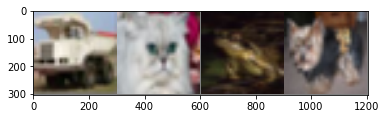

truck   cat  frog   dog


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[0], target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            # https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
            # Prevent system reboot
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(state, 'savepoint.pth.tar')
            
            # Pray that I don't need to use them
            #state = torch.load('savepoint.pth.tar')
            #model.load_state_dict(state['state_dict'])
            #optimizer.load_state_dict(state['optimizer'])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_test += list(target)
            y_pred += list(pred.view_as(target))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=classes, normalize=True,
                          title='Normalized confusion matrix')


# 1. Model

Use ready-made from [`PyTorch`](https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3)

In [8]:
from torchvision.models import Inception3
model = Inception3(num_classes=10, transform_input=True)

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [67]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', trainloader, optimizer, epoch, criterion)
    test(model, 'cpu', testloader, criterion)




  0%|          | 0/12500 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.446244





  0%|          | 1/12500 [00:02<8:11:20,  2.36s/it]


  0%|          | 2/12500 [00:03<7:08:39,  2.06s/it]


  0%|          | 3/12500 [00:04<6:17:56,  1.81s/it]


  0%|          | 4/12500 [00:06<5:44:50,  1.66s/it]


  0%|          | 5/12500 [00:07<5:20:38,  1.54s/it]


  0%|          | 6/12500 [00:08<4:59:59,  1.44s/it]Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/cond

KeyboardInterrupt: 

# Read the savepoint and do experiment

In [10]:
state = torch.load('savepoint.pth.tar')

model = Inception3(num_classes=10, transform_input=True)
model.load_state_dict(state['state_dict'])

criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(state['optimizer'])




Test set: Average loss: -0.5200, Accuracy: 4513/10000 (45%)

[[488  39 185  26  65   2  21  56  90  28]
 [ 42 685  16  60  17   0  16  36  48  80]
 [ 39  11 358 131 267  15  67 103   4   5]
 [ 15  16 120 376 175  69  98 111   1  19]
 [ 12   6 128  80 553   7  85 118   6   5]
 [  4   6 115 302 173 198  41 153   3   5]
 [  4   7  72 201 173  10 490  27   2  14]
 [  8  14  36  99 170  28  11 609   6  19]
 [220  97 124  49  71   1   7  37 351  43]
 [ 45 246  32  95  19   0  22  78  58 405]]


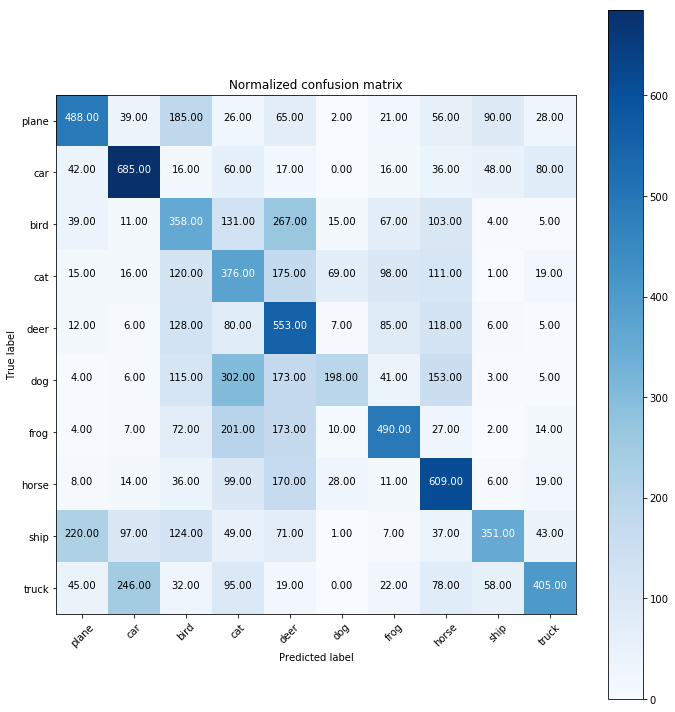

In [11]:
for epoch in range(1, 1 + 1):
    test(model, 'cpu', testloader)

# Scratch Note

In [13]:
target = torch.tensor([3, 2 ,2, 4], dtype=torch.long)
pred = torch.tensor([8,2,2,4], dtype=torch.long)

In [14]:
y_test = list(target)
y_pred = list(pred)

[[2 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]


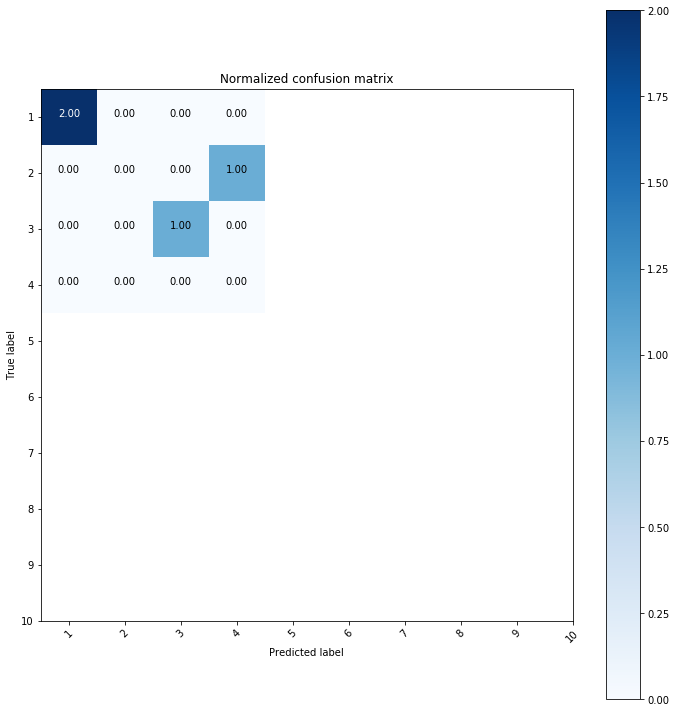

In [15]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                      title='Normalized confusion matrix')
